## SincNet Implementation

#### Задача

В рамках данной работы решалась задача speaker identification (статья https://arxiv.org/pdf/1808.00158.pdf). Данная архитектура также подходит для задачи speaker verification и некоторых других.

#### Архитектура

Данная архитектура имеет сверточные 1d слои, особенность заключается в структуре первого слоя, остальные слои - стандартная свертка Conv1d. Ядра первого слоя сверток представляют из себя симметричные функции $g(n)=2f_2sinc(2πf_2n)−2f_1sinc(2πf_1n)$ для $n \in [-k,k]$, имеющие всего 2 параметра, в то время как стандартная свертка размера 2k имеет 2k параметров. То есть если в слое F фильторов и ядра свертки длины $l$, то в стандартном сверточном слое будет $F\cdot l$ парметров, а в Sinc слое всего $2F$. 

$$sinc(x)=\frac{sin(x)}{x}$$

Идея подхода заключается в том, чтобы помочь ядру научиться выделять значимые признаки за счет более жесткого ограничения на его вид. Утверждается, что ядра на ранних слоях должны представлять из себя частотные фильтры (в статье демонстрируется, что примерно так это и происходит при обучении стандартной сверточной архитектуры), поэтому предлагается искусственно сделать каждое ядро фильтром, пропускающим частоты в диапазоне от $f_1$ до $f_2$. Применив обратное преобразование Фурье к прямоугольному спектру, мы и получаем функцию $g(n)$, выписанную выше. Обучаемыми параметрами такой функции являются крайние частоты прямоугольного спектра $f_2$ и $f_1$.

Благодаря меньшему количеству параметров и возможности сразу ("из коробки") выделять определенные частоты такие слои будут быстрее обучаться и будут меньше подвержены переобучению.

В архитектуре из данной статьи только первый слой представляет из себя свертку с sinc ядрами, последующие слои являются обычными свертками Conv1d, после чего идут полносвязные слои. Задача speaker identification решается, как стандартная классификация с функцией ошибки категориальной кросс-энтропией.

#### Эксперимент

Сеть обучалась на датсете TIMIT, который использовался в оригинальной статье. Данные были предобработаны с помощью модуля TIMIT_preparation.py, взятого из репозитория автора статьи (https://github.com/mravanelli/SincNet). Этот модуль обрезает тишину в начале и конце записей и нормирует амплитуду.

Архитектура модели была максимально приближена к авторской. Проводились эксперименты с разными размерами батчей, архитектура не модифицировалась. Процесс обучения можно посмотреть в SincNet_train.ipynb (обучение проводилось на google colab)

Результаты экспериментов:

In [67]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

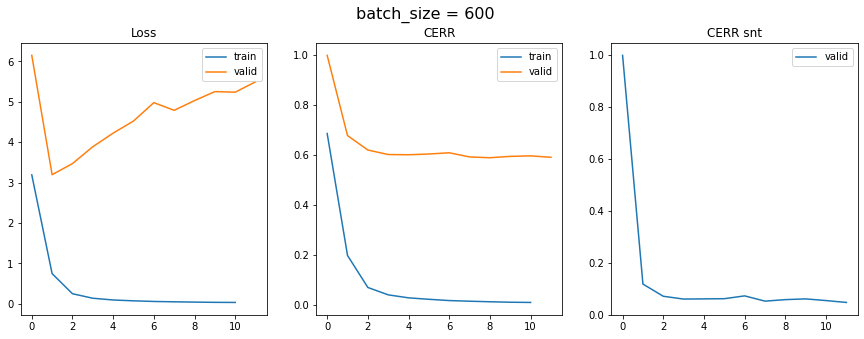

In [86]:
batch_size = 600

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'batch_size = {batch_size}', fontsize=16)
ax[0].set_title('Loss')
ax[0].plot(np.load(f'experiments\\train_loss_{batch_size}.npy'), label='train')
ax[0].plot(np.load(f'experiments\\val_loss_{batch_size}.npy'), label='valid')
ax[0].legend()
ax[1].set_title('CERR')
ax[1].plot(np.load(f'experiments\\train_cerr_{batch_size}.npy'), label='train')
ax[1].plot(np.load(f'experiments\\val_cerr_{batch_size}.npy'), label='valid')
ax[1].legend()
ax[2].set_title('CERR snt')
ax[2].plot(np.load(f'experiments\\val_cerr__snt_{batch_size}.npy'), label='valid')
ax[2].legend()
plt.show()

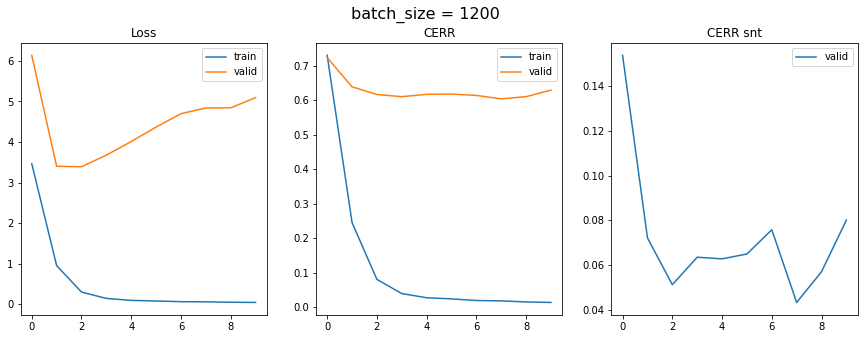

In [87]:
batch_size = 1200

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'batch_size = {batch_size}', fontsize=16)
ax[0].set_title('Loss')
ax[0].plot(np.load(f'experiments\\train_loss_{batch_size}.npy'), label='train')
ax[0].plot(np.load(f'experiments\\val_loss_{batch_size}.npy'), label='valid')
ax[0].legend()
ax[1].set_title('CERR')
ax[1].plot(np.load(f'experiments\\train_cerr_{batch_size}.npy'), label='train')
ax[1].plot(np.load(f'experiments\\val_cerr_{batch_size}.npy'), label='valid')
ax[1].legend()
ax[2].set_title('CERR snt')
ax[2].plot(np.load(f'experiments\\val_cerr__snt_{batch_size}.npy'), label='valid')
ax[2].legend()
plt.show()

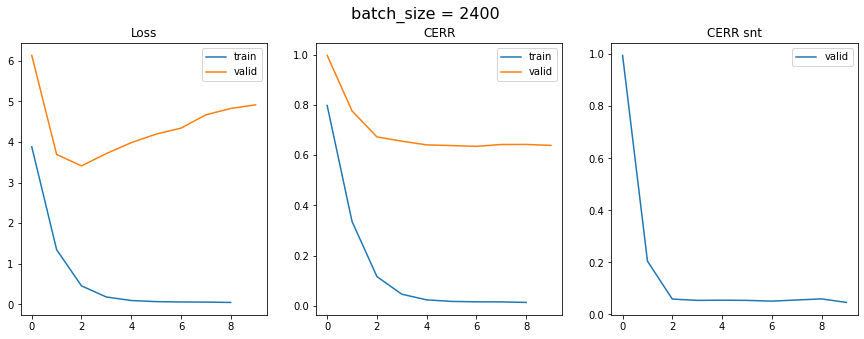

In [88]:
batch_size = 2400

fig, ax = plt.subplots(1,3, figsize=(15,5))
fig.suptitle(f'batch_size = {batch_size}', fontsize=16)
ax[0].set_title('Loss')
ax[0].plot(np.load(f'experiments\\train_loss_{batch_size}.npy'), label='train')
ax[0].plot(np.load(f'experiments\\val_loss_{batch_size}.npy'), label='valid')
ax[0].legend()
ax[1].set_title('CERR')
ax[1].plot(np.load(f'experiments\\train_cerr_{batch_size}.npy'), label='train')
ax[1].plot(np.load(f'experiments\\val_cerr_{batch_size}.npy'), label='valid')
ax[1].legend()
ax[2].set_title('CERR snt')
ax[2].plot(np.load(f'experiments\\val_cerr__snt_{batch_size}.npy'), label='valid')
ax[2].legend()
plt.show()

CERR - Classification error rate для кусков высказываний, которые подавались в модель

CERR snt - процент ошибок в классификации предложений в случая усреднения предсказаний по всем кускам.

Лучшее итоговое значение CERR snt - 0.046. В статье приведено значение 0.006, что существенно ниже полученного.

#### Интерпретация результатов

Главной проблемой было переобучение. В авторской архитектуре не было Dropout, видимо, авторы боролись с переобучением за счет маленьких батчей, однако в рамках данной работы не получилось провести таких экспериментов из трудностей с длительным обучением на google colab. 

В рамках дальнейшего исследования можно провести обучение с маленьким батчем в течение длительного времени и провести эксперименты с модифицированием архитектуры (к примеру, добавив Dropout)

#### Перспективы развития

На мой взгляд идея использования sinc свертки очень перспективна. Она существенно сокращает количество параметров и позволяет дать прирост в скорости обучения (по словам авторов статьи). Такие слои можно использовать практически в любой сверточной архитектуре для анализа аудио сигнала в качестве первых слоев нейросети, которые выделяют первичные фичи, то есть решение универсально.